# 1.1

In [44]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [45]:
def sample_ER(N, p):
    rd = np.random.rand(N,N)
    A = np.triu(rd < (p))
    np.fill_diagonal(A, 0)
    return A

In [46]:
def gen_com_graph(N, n_coms, p_high, p_low):
    N_pc = int(N / n_coms)
    A_struct = np.zeros((N,N))
    for i in range(n_coms):
        A_struct[i*N_pc:(i+1)*N_pc, i*N_pc:(i+1)*N_pc] = sample_ER(N_pc, p_high)
    A_random = sample_ER(N, p_low)
    A = A_struct + A_random
    
    return nx.from_numpy_matrix(A), A_struct, A_random

In [ ]:
N = 33
G, A_struct, A_random = gen_com_graph(N, 1, 0.25, 0.004)



[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


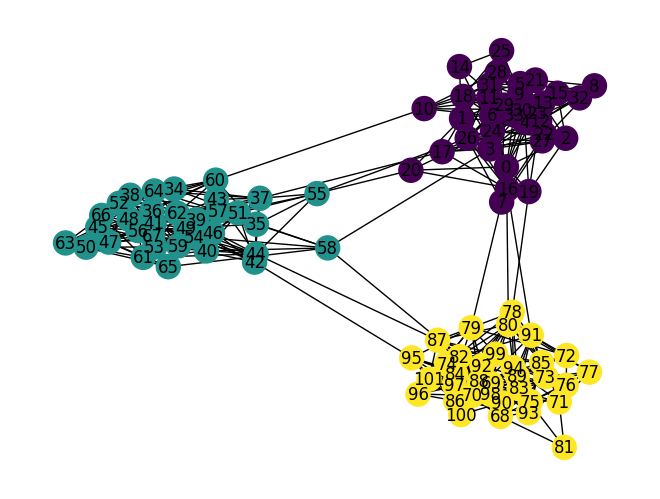

In [98]:
N = 102
G, A_struct, A_random = gen_com_graph(N, 3, 0.25, 0.004)

groups = np.zeros(N)
for i in range(3):
    groups[i*int(N/3):(i+1)*int(N/3)] = i
   
print(nx.to_numpy_array(G))
nx.draw(G, node_color=groups, with_labels=True)

# 1.2

In [7]:
def solve_cons_dyn(G, x0, t):
    L = nx.laplacian_matrix(G).toarray()
    return np.dot(scipy.linalg.expm(-t * L), x0)

# 1.3

In [136]:
def evolve_cons_dyn(G, N, x0, timeline, axis):
    axis.set_xscale('log')
    axis.set_ylabel('time (t)')
    axis.set_xlabel('x(t)')

    sol = np.zeros((N,len(timeline)))
    
    j = 0
    for t in timeline:
        sol[:,j] = solve_cons_dyn(G, x0, t)
        j += 1
        
    for i in range(N):
        axis.plot(timeline, sol[i,:])

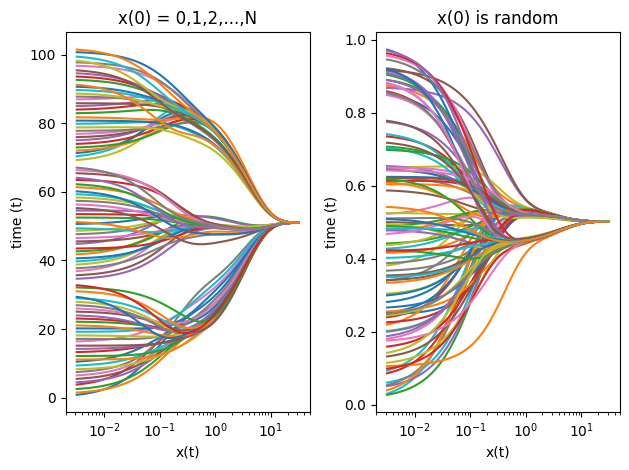

In [137]:
timeline = np.logspace(-2.5,1.5,100)
x0 = np.linspace(0, N, N)

fig1, axes = plt.subplots(1, 2)

evolve_cons_dyn(G, N, x0, timeline, axes[0])
axes[0].set_title('x(0) = 0,1,2,...,N')

x0 = np.random.rand(N)
evolve_cons_dyn(G, N, x0, timeline, axes[1])
axes[1].set_title('x(0) is random')

fig1.tight_layout()

# 1.4

In [111]:
laps = []
laps.append(nx.laplacian_matrix(G).toarray())
laps.append(nx.laplacian_matrix(nx.from_numpy_matrix(A_struct)).toarray())
laps.append(nx.laplacian_matrix(nx.from_numpy_matrix(A_random)).toarray())

names = ['L', 'L_struct', 'L_rand']

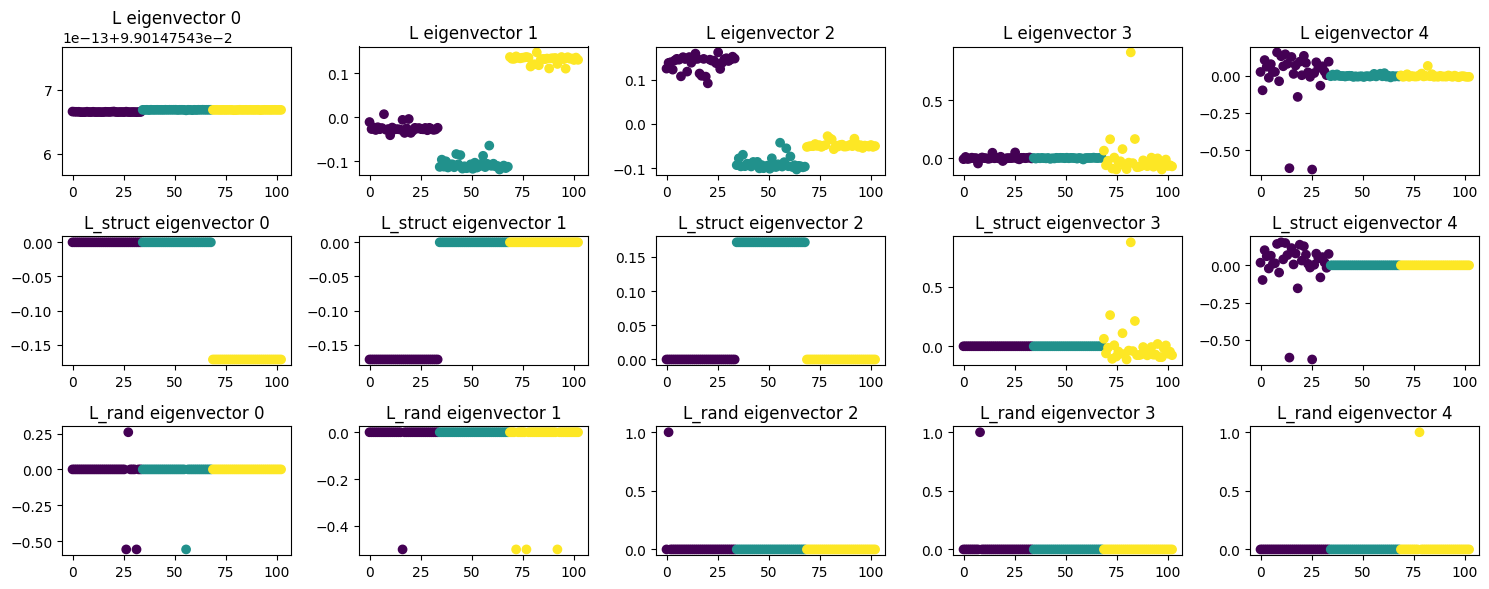

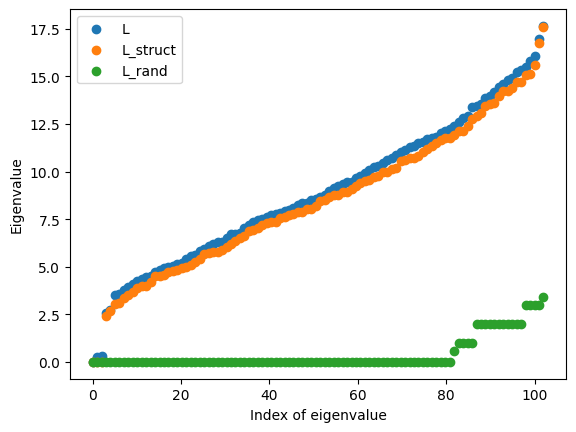

In [116]:
fig1, axes = plt.subplots(3, 5, figsize=(15, 6))
fig2, axis = plt.subplots()

ws = []
vs = []
for i in range(3):
    
    # eigenvalues, eigenvectors
    w, v = np.linalg.eigh(laps[i])
    
    axis.scatter(np.linspace(0, len(w), len(w)), w)
    #axes[0,i].set_title(names[i])

    # sort eigvectors by eigenvalue

    idx = w.argsort()
    
    w = w[idx]
    v = v[:,idx]

    ws.append(w)
    vs.append(v)
    
    # plot eigenvectors
    for j in range(5):
        axes[i,j].scatter(np.linspace(0, len(v[j]), len(v[j])), v[:,j], c=groups)
        axes[i,j].set_title(names[i] + ' eigenvector ' + str(j))

axis.legend(names)
axis.set_ylabel('Eigenvalue')
axis.set_xlabel('Index of eigenvalue')

fig1.tight_layout()


In [117]:
# compute valid epsilon
L_rand_norm = np.linalg.norm(laps[2])
epsilon = L_rand_norm * 1.1
print("Epsilon is ", epsilon)

# Verify Weyl's perturbation theorem
for i in range(min(len(ws[0]), len(ws[1]))):
    if abs(ws[0][i] - ws[1][i]) > epsilon:
        raise Exception('Weyl\'s perturbation theorem is not valid')

print('Weyl\'s perturbation theorem is valid')


Epsilon is  10.777754868245983
Weyl's perturbation theorem is valid


- Most eigenvalues of the random component are 0 where three plateaus are visible. 
- L and L_struct follow an almost uniform distribution of eigenvalues
- For most of the eigenvectors a clustering of its componenet values are visible which translate exactly to the clustertin in the original graph.


# 1.5


In [123]:
# function to solve the conseous dynamics approximately
# Generally we feed it with the eigenvectors associated with the smallest eigenvalues to yield better results
def solve_cons_dyn2(G, x0, t, eigenvalues, eigenvectors):
    x = np.zeros(len(x0))
    for i in range(len(eigenvalues)):
        x += np.exp(-t * eigenvalues[i]) * np.dot(eigenvectors[:,i], x0) * eigenvectors[:,i]
    return x

# 1.6

In [140]:
def evolve_cons_dyn_approx(G, N, x0, timeline, axis, start_eig, end_eig):
    axis.set_xscale('log')
    axis.set_ylabel('time (t)')
    axis.set_xlabel('x(t)')

    sol = np.zeros((N,len(timeline)))

    L = nx.laplacian_matrix(G).toarray()
    w, v = np.linalg.eigh(L)
    idx = w.argsort()
    w = w[idx]
    v = v[:,idx]
    
    j = 0
    for t in timeline:
        sol[:,j] = solve_cons_dyn2(G, x0, t, w[start_eig:end_eig], v[:,start_eig:end_eig])
        j += 1
        
    for i in range(N):
        axis.plot(timeline, sol[i,:])

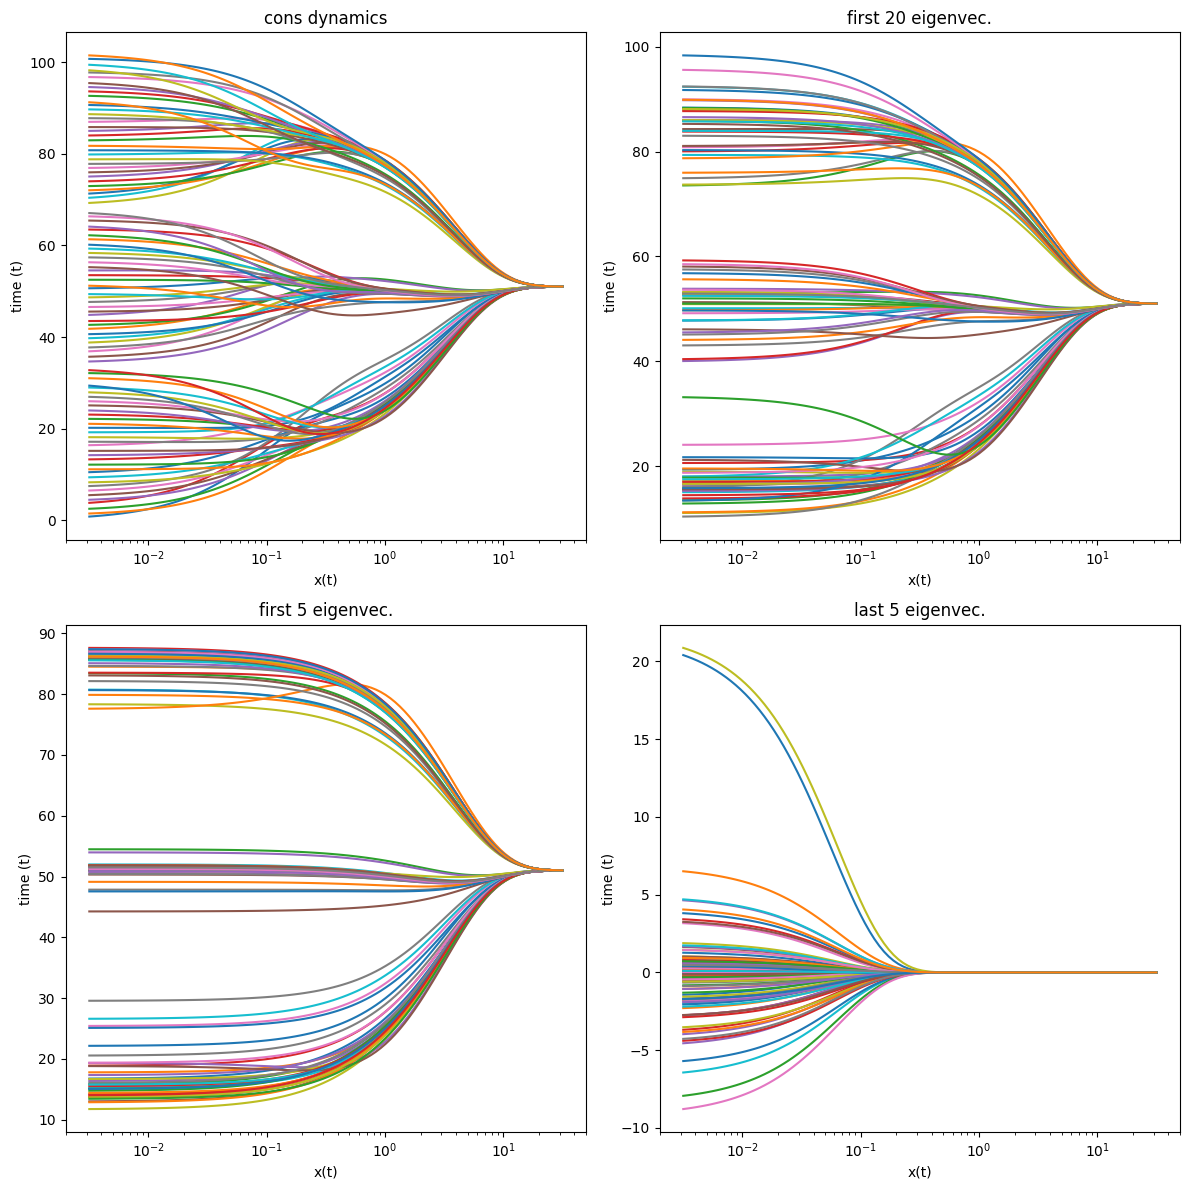

In [143]:
timeline = np.logspace(-2.5,1.5,100)
x0 = np.linspace(0, N, N)

fig1, axes = plt.subplots(2, 2, figsize=(12, 12))

evolve_cons_dyn(G, N, x0, timeline, axes[0,0])
axes[0,0].set_title('cons dynamics')

x0 = np.linspace(0, N, N)
evolve_cons_dyn_approx(G, N, x0, timeline, axes[0,1], 0, 20)
axes[0,1].set_title('first 20 eigenvec.')

x0 = np.linspace(0, N, N)
evolve_cons_dyn_approx(G, N, x0, timeline, axes[1,0], 0, 5)
axes[1,0].set_title('first 5 eigenvec.')

x0 = np.linspace(0, N, N)
evolve_cons_dyn_approx(G, N, x0, timeline, axes[1,1], N-5, N)
axes[1,1].set_title('last 5 eigenvec.')

fig1.tight_layout()

As suspected, when trying to use the last 5 eigevectors, the result is not correct at all, while even the first 5 eigenvectors yield a somwhat plaubsible graph.

# 1.7

A possible explanation for this is that 